In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import keras.backend as K

Using TensorFlow backend.


In [50]:
sample_inputs = [np.random.randn(10) for _ in range(100)]
sample_sets = [np.array(random.sample(sample_inputs, 1)) for _ in range(10)]
sample_sets.extend([np.array(random.sample(sample_inputs, 2)) for _ in range(10)])
sample_sets.extend([np.array(random.sample(sample_inputs, 3)) for _ in range(10)])
sample_sets.extend([np.array(random.sample(sample_inputs, 4)) for _ in range(10)])
sample_sets.extend([np.array(random.sample(sample_inputs, 5)) for _ in range(10)])
random.shuffle(sample_sets)
sample_labels = np.random.randint(0, 8, size=(len(sample_sets),))
sample_sets[:3], sample_labels[:3]

([array([[-0.8792067 , -1.95370861,  0.24549134,  0.08399273, -0.07113309,
           0.07218999,  0.07064712,  0.64412921,  1.47752434, -0.33850301],
         [-1.13720259,  0.05331104, -0.14083283, -0.31437643,  1.05394189,
           0.8845395 , -0.4624281 , -1.19483199,  1.45128951, -0.10391425]]),
  array([[ 0.24439909,  0.85077439,  0.27694415,  0.42373125,  0.86429   ,
           0.36670427,  1.04171164,  1.78495388, -1.20602277,  1.76998246]]),
  array([[ 0.37227115, -1.35360289,  0.84305762, -1.15194611, -0.44141736,
           0.50321601,  0.43662711,  0.16342058,  0.89492558, -0.95855094],
         [-0.34303086,  0.96655656,  0.54152572, -0.0059723 , -1.08553269,
          -0.29529072,  1.86948025, -0.23876265, -1.68270647,  0.44041231],
         [ 1.19601277,  1.33404846,  1.09944856,  0.60159519,  2.25938124,
           0.20225236,  2.14814688,  2.17600008,  0.04814916,  0.24693039],
         [-0.82712025,  1.86784638, -1.83448442, -1.36073505,  0.97458299,
          -1.83

In [51]:
K.clear_session()
L_dense_1 = keras.layers.Dense(10, activation='relu')
L_att_c = keras.layers.Concatenate()
L_att_1 = keras.layers.Dense(1, activation='relu')
L_att_s = keras.layers.Softmax(-2)
L_att_d = keras.layers.Dot(-2)
L_att_p = keras.layers.Permute([2, 1])
L_dec_lstm = keras.layers.LSTM(10, return_state=True)
L_dec_1 = keras.layers.Dense(8, activation='softmax')
Ms = []
for i in range(1, 6):
    L = L_input = keras.layers.Input((i, 10))
    L_att_pre = keras.layers.TimeDistributed(L_dense_1)(L)
    L_dec_init_h = keras.layers.Input((10,))
    L_dec_init_c = keras.layers.Input((10,))
    L_dec_state = (L_dec_init_h, L_dec_init_c)
    L_att_1_td = keras.layers.TimeDistributed(L_att_1)
    L_att_outs = []
    for j in range(i):
        L_att = L_att_c([L_att_pre, keras.layers.RepeatVector(i)(L_dec_state[0])])
        L_att = L_att_1_td(L_att)
        L_att = L_att_s(L_att)
        L_att_outs.append(L_att)
        L = L_att_d([L_att_pre, L_att])
        L = L_att_p(L)
        L, L_dec_lstm_h, L_dec_lstm_c = L_dec_lstm(L, initial_state=L_dec_state)
        L_dec_state = (L_dec_lstm_h, L_dec_lstm_c)
        L = L_dec_1(L)
    M_main = keras.models.Model([L_input, L_dec_init_h, L_dec_init_c], [L])
    M_main.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
    M_main.summary()
    L_att_outs = keras.layers.Lambda(lambda x: K.squeeze(K.stack(x if isinstance(x, list) else [x], axis=-2), axis=-1))(L_att_outs)
    M_att = keras.models.Model([L_input, L_dec_init_h, L_dec_init_c], [L_att_outs])
    M_att.compile('adam', 'mse', metrics=['accuracy'])
    Ms.append((M_main, M_att))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 10)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 1, 10)        110         input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 1, 10)        0           input_2[0][0]                    
__________________________________________________________________________________________________
concatenat

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 4, 10)        0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
time_distributed_7 (TimeDistrib (None, 4, 10)        110         input_10[0][0]                   
__________________________________________________________________________________________________
repeat_vector_7 (RepeatVector)  (None, 4, 10)        0           input_11[0][0]                   
__________________________________________________________________________________________________
concatenat

In [52]:
for epoch in range(10000):
    verbose = epoch % 100 == 0
    i = random.randint(0, len(sample_sets)-1)
    sample_set = sample_sets[i:i+1]
    sample_label = keras.utils.to_categorical(sample_labels[i:i+1], num_classes=8)
    sample_set_len = sample_set[0].shape[0]
    if verbose:
        print('epoch', epoch)
    Ms[sample_set_len-1][0].fit(
        [np.array(sample_set), np.zeros((1,10)), np.zeros((1,10))],
        [np.array(sample_label)],
        verbose=verbose)

epoch 0
Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 2.0605 - acc: 0.0000e+00
epoch 100
Epoch 1/1
1/1 [==============================] - 0s 15ms/step - loss: 1.9595 - acc: 0.0000e+00
epoch 200
Epoch 1/1
1/1 [==============================] - 0s 11ms/step - loss: 2.2042 - acc: 0.0000e+00
epoch 300
Epoch 1/1
1/1 [==============================] - 0s 13ms/step - loss: 2.3074 - acc: 0.0000e+00
epoch 400
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 2.0044 - acc: 0.0000e+00
epoch 500
Epoch 1/1
1/1 [==============================] - 0s 13ms/step - loss: 1.9369 - acc: 0.0000e+00
epoch 600
Epoch 1/1
1/1 [==============================] - 0s 11ms/step - loss: 2.1288 - acc: 0.0000e+00
epoch 700
Epoch 1/1
1/1 [==============================] - 0s 8ms/step - loss: 1.9808 - acc: 0.0000e+00
epoch 800
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 2.0385 - acc: 0.0000e+00
epoch 900
Epoch 1/1
1/1 [==============================] - 0s 

epoch 8100
Epoch 1/1
1/1 [==============================] - 0s 8ms/step - loss: 0.1673 - acc: 1.0000
epoch 8200
Epoch 1/1
1/1 [==============================] - 0s 9ms/step - loss: 0.0750 - acc: 1.0000
epoch 8300
Epoch 1/1
1/1 [==============================] - 0s 13ms/step - loss: 0.0023 - acc: 1.0000
epoch 8400
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.0756 - acc: 1.0000
epoch 8500
Epoch 1/1
1/1 [==============================] - 0s 13ms/step - loss: 0.5394 - acc: 1.0000
epoch 8600
Epoch 1/1
1/1 [==============================] - 0s 9ms/step - loss: 0.0162 - acc: 1.0000
epoch 8700
Epoch 1/1
1/1 [==============================] - 0s 14ms/step - loss: 0.0160 - acc: 1.0000
epoch 8800
Epoch 1/1
1/1 [==============================] - 0s 16ms/step - loss: 0.0353 - acc: 1.0000
epoch 8900
Epoch 1/1
1/1 [==============================] - 0s 11ms/step - loss: 0.0168 - acc: 1.0000
epoch 9000
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 0.0244

In [90]:
def test(i):
    sample_set = sample_sets[i]
    sample_set_asc = sample_set[np.argsort(sample_set[:,0])]
    sample_set_desc = sample_set[np.argsort(sample_set[:,0])[::-1]]
    sample_set_len = sample_set.shape[0]
    samples = [sample_set_asc, sample_set_desc]
    pred = Ms[sample_set_len-1][0].predict(
        [np.array(samples), np.zeros((2,10)), np.zeros((2,10))])
    att = Ms[sample_set_len-1][1].predict(
        [np.array(samples), np.zeros((2,10)), np.zeros((2,10))])
    plt.imshow(sample_set_asc)
    plt.title('input seq sorted asc')
    plt.ylabel('time')
    plt.show()
    print('attention:')
    print(att[0])
    print('prediction', pred[0:1,:])
    plt.imshow(sample_set_desc)
    plt.title('input seq sorted desc')
    plt.ylabel('time')
    plt.show()
    print('attention:')
    print(att[1])
    print('prediction', pred[1:2,:])

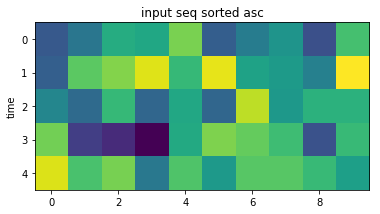

attention:
[[0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]]
prediction [[9.9891770e-01 6.1265251e-05 4.8377246e-05 3.0995378e-07 7.5310731e-04
  6.5333478e-07 1.0233720e-04 1.1634163e-04]]


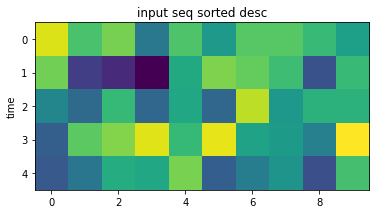

attention:
[[0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]
 [0.2 0.2 0.2 0.2 0.2]]
prediction [[9.9891770e-01 6.1265251e-05 4.8377246e-05 3.0995378e-07 7.5310731e-04
  6.5333478e-07 1.0233730e-04 1.1634163e-04]]


In [91]:
test(4)